In [4]:
import torch
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
seed = 221
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Loading Dataset

In [45]:
train = pd.read_csv('../train.csv', index_col=0)
val = pd.read_csv('../valid.csv', index_col=0)
test = pd.read_csv('../test.csv', index_col=0)

In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11426 entries, 0 to 11425
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   11426 non-null  object
 1   sentiment  11426 non-null  int64 
 2   topic      11426 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 357.1+ KB


In [47]:
train.drop(columns=['topic'], axis=1, inplace=True)
val.drop(columns=['topic'], axis=1, inplace=True)
test.drop(columns=['topic'], axis=1, inplace=True)

In [48]:
train = pd.concat([train, val])

In [49]:
test['sentiment'].unique()

array([2, 0, 1], dtype=int64)

In [50]:
train.head()

,sentence,sentiment
0,slide giáo trình đầy đủ .,2
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",2
2,đi học đầy đủ full điểm chuyên cần .,0
3,chưa áp dụng công nghệ thông tin và các thiết ...,0
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",2


# Random Forest + TF-IDF

In [51]:
x_train = train['sentence'].to_list()
y_train = train['sentiment'].to_list()

x_test = test['sentence'].to_list()
y_test = test['sentiment'].to_list()

In [52]:
vietnamese_stopwords = pd.read_csv('../vietnamese-stopwords.txt', header=None, sep='\n')
vietnamese_stopwords = vietnamese_stopwords[0].to_list()

In [53]:
tfidf = TfidfVectorizer(smooth_idf=True, strip_accents='unicode', stop_words=vietnamese_stopwords, lowercase=True, encoding='utf-8', analyzer='word', ngram_range=(1, 3), max_features=5000)

In [54]:
encoded_x_train = tfidf.fit_transform(x_train)
encoded_x_test = tfidf.transform(x_test)

c:\Users\Admin\.conda\envs\cs115\lib\site-packages\sklearn\feature_extraction\text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['alo', 'an', 'ang', 'ao', 'at', 'au', 'ay', 'bac', 'bai', 'ban', 'bang', 'bao', 'bap', 'bat', 'bay', 'ben', 'beng', 'bet', 'bi', 'bien', 'biet', 'bo', 'boi', 'bom', 'bong', 'buc', 'buoc', 'buoi', 'ca', 'cac', 'cach', 'cai', 'cam', 'can', 'cang', 'canh', 'cap', 'cat', 'cau', 'cay', 'chac', 'cham', 'chan', 'chang', 'chanh', 'chao', 'chap', 'chay', 'chet', 'chi', 'chia', 'chiec', 'chin', 'chinh', 'chiu', 'choc', 'choi', 'chon', 'chot', 'chu', 'chua', 'chuan', 'chui', 'chun', 'chuyen', 'co', 'coc', 'coi', 'cong', 'cu', 'cua', 'cuc', 'cung', 'cuoc', 'cuoi', 'cuon', 'da', 'dai', 'dan', 'danh', 'dao', 'dau', 'de', 'di', 'dip', 'du', 'dung', 'duoi', 'gan', 'gap', 'gay', 'gi', 'gia', 'giac', 'giam', 'gian', 'gio', 'gioi', 'giong', 'giu', 'giua', 'gom', 'ha', 'han', 'hau', 'hen', 'het', 'hi

In [55]:
encoded_x_train

<13009x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 266049 stored elements in Compressed Sparse Row format>

In [56]:
random_forest = RandomForestClassifier(criterion='gini', bootstrap=True, n_estimators=100, random_state=seed)

In [57]:
random_forest

RandomForestClassifier(random_state=221)

In [58]:
random_forest.fit(encoded_x_train, y_train)

RandomForestClassifier(random_state=221)

In [59]:
predict = random_forest.predict(encoded_x_test)
predict

array([2, 2, 2, ..., 2, 2, 0])

In [60]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      1409
           1       0.50      0.11      0.18       167
           2       0.91      0.87      0.89      1590

    accuracy                           0.86      3166
   macro avg       0.74      0.64      0.65      3166
weighted avg       0.85      0.86      0.85      3166



In [61]:
input = ["Thầy dạy dễ hiểu"]
x = tfidf.transform(input)
random_forest.predict(x)

array([2])

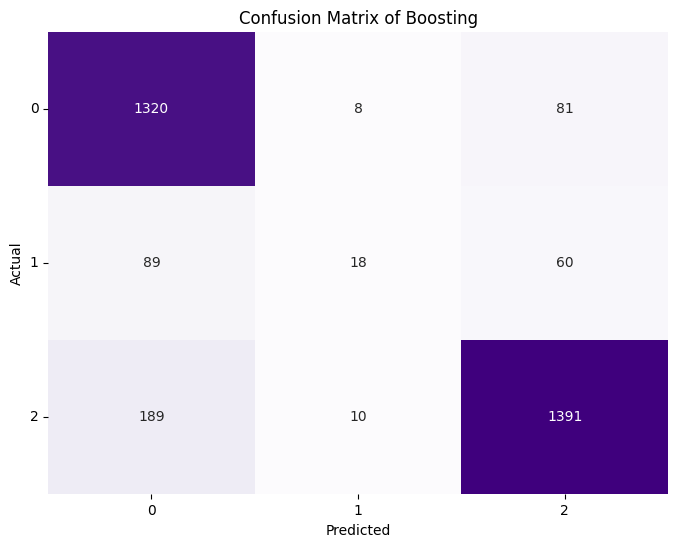

In [64]:
conf_ma = confusion_matrix(y_test, predict)
labels = ['0', '1', '2'] # 0: negative, 1: neutral, 2: positive
plt.figure(figsize=(8, 6))
sns.heatmap(conf_ma, annot=True, cmap='Purples', fmt='g', cbar=False)

# Add labels, title, and ticks
plt.title('Confusion Matrix of Boosting')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(len(labels)) + 0.5, labels)
plt.yticks(np.arange(len(labels)) + 0.5, labels, rotation=0)
plt.show()